# 三种版本的 DFL

In [1]:
import set_env
from d2py.utils.file import mkdir
root_dir = ".temp"
mkdir(f"{root_dir}/logs")

In [2]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.onnx import OperatorExportTypes, utils


class DFLV1(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """

    def __init__(self, c1=16):
        """Initialize a convolutional layer with a given number of input channels."""
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        x = x.view(b, 4, self.c1, a)
        x = x.transpose(3, 1).transpose(2, 3)
        x = x.softmax(3)
        x = x.transpose(3, 1)
        x = self.conv(x)
        return x.view(b, 4, a)
    
class DFLV2(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """

    def __init__(self, c1=16):
        """Initialize a convolutional layer with a given number of input channels."""
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)

class DFLV3(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """

    def __init__(self, c1=16):
        """Initialize a convolutional layer with a given number of input channels."""
        super().__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, self.c1, 4, a).softmax(1)).view(b, 4, a)

class DFL(nn.Module):
    def __init__(self, c1=16):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 16, 1, bias=False)
        self.conv1 = nn.Conv2d(16, 64, 1, bias=False)
        self.conv2 = nn.Conv2d(16, 64, 1, bias=False)
        self.conv3 = nn.Conv2d(16, 100, 1, bias=False)
        self.v1 = DFLV1(c1)
        self.v2 = DFLV2(c1)
        self.v3 = DFLV3(c1)
    
    def forward(self, x):
        x = self.conv0(x)
        x1 = self.conv1(x).view(1, 64, -1)
        x2 = self.conv2(x).view(1, 64, -1)
        x3 = self.conv3(x).view(1, 64, -1)
        x1 = self.v1(x1)
        x2 = self.v2(x2)
        x3 = self.v3(x3)
        return x1, x2, x3

In [3]:
model = DFL().eval()

shape = 1, 3, 48, 80
xx = torch.rand(*shape, dtype=torch.float32, requires_grad=False)
# model = torch.jit.trace(model, xx)
# 导出模型
input_name = "data"
output_name = "dfl"
utils.export(
    model,               # torch 模型
    xx,                         # 模型输入或者对于多个输入，使用元组
    f"{root_dir}/{output_name}.onnx",               # 模型保存的位置（可以是文件或类似文件的对象）
    export_params=True,        # 将训练后的参数权重存储在模型文件内
    opset_version=17,          # 导出模型的 ONNX 版本
    do_constant_folding=True,  # 是否执行常量折叠以进行优化
    input_names = [input_name],    # 模型的输入名称
    output_names = ['output'], # 模型的输出名称
    keep_initializers_as_inputs=True,
    # export_modules_as_functions=True,
    verbose=True,
    operator_export_type=OperatorExportTypes.ONNX_FALLTHROUGH,
    # dynamic_axes={'data' : {0 : 'batch_size'},    # 可变长度的轴
    #               'output' : {0 : 'batch_size'}}
)

Exported graph: graph(%data : Float(1, 3, 48, 80, strides=[11520, 3840, 80, 1], requires_grad=0, device=cpu),
      %conv0.weight : Float(16, 3, 1, 1, strides=[3, 1, 1, 1], requires_grad=1, device=cpu),
      %conv1.weight : Float(64, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %conv2.weight : Float(64, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %conv3.weight : Float(100, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cpu),
      %v1.conv.weight : Float(1, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=0, device=cpu),
      %v2.conv.weight : Float(1, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=0, device=cpu),
      %v3.conv.weight : Float(1, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=0, device=cpu)):
  %/conv0/Conv_output_0 : Float(1, 16, 48, 80, strides=[61440, 3840, 80, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/conv0/Co

In [4]:
from copy import deepcopy
import onnx
import tvm
from tvm import relay
onnx_model = onnx.load(f"{root_dir}/{output_name}.onnx")
mod, params = relay.frontend.from_onnx(onnx_model, {"data": shape}, freeze_params=True)
mod = relay.transform.InferType()(mod)
origin_mod = deepcopy(mod)
# with tvm.transform.PassContext(opt_level=3):
#     mod = relay.quantize.prerequisite_optimize(mod, params)
mod.show()

## 注册算子 `vta_special.yolo_dfl`

In [5]:
import numpy as np
from tvm.relay.testing import run_infer_type
from tvm.relay.dataflow_pattern import (
    wildcard, is_op,
    is_constant,
    DFPatternCallback,
    rewrite
)
import tvm
from tvm.ir.attrs import DictAttrs
from tvm.relay import transform as _transform
from tvm import relay, te, topi
from tvm.relay.op import op as _op
from tvm.target import generic_func

@generic_func
def schedule_special_op(attrs, outs, target):
    with target:
        outs = [outs] if isinstance(outs, te.tensor.Tensor) else outs
        output = outs[0]
        sch = te.create_schedule(output.op)   
        return sch

In [6]:
def custom_yolo_dfl_rel(arg_types, attrs):
    assert len(arg_types) == 1, "type relation arg number mismatch!"
    if attrs:
        assert isinstance(attrs, DictAttrs)
    in_shape = attrs.in_shape
    bbox_size = 4
    assert in_shape[1]%bbox_size == 0
    out_shape = (in_shape[0], bbox_size, in_shape[2])
    return relay.TensorType(out_shape, "float32")

op_name = "vta_special.yolo_dfl"
_op.register(op_name, r"code(cal yolo_dfl.)code")
_op.get(op_name).set_num_inputs(1)
_op.get(op_name).add_argument("data", "Tensor", "The input data tensor.")
_op.get(op_name).set_attrs_type_key("DictAttrs")
_op.get(op_name).add_type_rel(op_name, custom_yolo_dfl_rel)
_op.get(op_name).set_support_level(1)
_op.register_pattern(op_name, _op.OpPattern.COMM_REDUCE)
_op.register_stateful(op_name, False) # 无状态算子

In [9]:
def yolo_dfl(x, channel, in_shape, version="v3", x_scale=-1, x_split=-1):
    attrs = tvm.ir.make_node(
        "DictAttrs",
        channel=channel, in_shape=in_shape, version=version,
        x_scale=x_scale, x_split=x_split,
    )
    return relay.Call(_op.get(op_name), [x], attrs=attrs, type_args=None, span=None)

@_op.register_compute(op_name)
def output_yolo_dfl_compute(attrs, inputs, out_type):
    """yolo_dfl Relay 计算"""
    assert len(inputs) == 1, "输入参数数量不为 1"
    x = inputs[0]
    b, c, a = attrs.in_shape # batch, channels, anchors 
    assert c % 4 == 0
    if x.dtype == "int8":
        x = topi.cast(x, "float32")
        x = topi.multiply(x, attrs.x_scale)
    w = topi.arange(0, attrs.channel, dtype="float32")
    w = topi.reshape(w, (1, attrs.channel, 1, 1))
    if attrs.version == "v3":
        x = topi.reshape(x, (b, c//4, 4, a))
        x = topi.nn.softmax(x, axis=1)
        x = topi.nn.conv2d(x, w, padding=[0, 0, 0, 0], strides=(1, 1), dilation=(1, 1))
        x = topi.reshape(x, (b, 4, a))
    elif attrs.version == "v2":
        x = topi.reshape(x, (b, 4, c//4, a))
        x = topi.transpose(x, [0, 2, 1, 3])
        x = topi.nn.softmax(x, axis=1)
        x = topi.nn.conv2d(x, w, padding=[0, 0, 0, 0], strides=(1, 1), dilation=(1, 1))
        x = topi.reshape(x, (b, 4, a))
    elif attrs.version == "v1":
        x = topi.reshape(x, (b, 4, c//4, a))
        x = topi.transpose(x, [0, 3, 1, 2])
        x = topi.nn.softmax(x, axis=3)
        x = topi.transpose(x, [0, 3, 2, 1])
        x = topi.nn.conv2d(x, w, padding=[0, 0, 0, 0], strides=(1, 1), dilation=(1, 1))
        x = topi.reshape(x, (b, 4, a))
    else:
        raise TypeError(f"暂未支持 {attrs.version}")
    return [x]

_op.register_schedule(op_name, schedule_special_op) # 定义调度

GenericFunc(0x9c088c0)

In [10]:
class DFLV1Rewrite(DFPatternCallback):
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.reshape = is_op("reshape")(self.x)
        self.transpose = is_op("transpose")(self.reshape).has_attr({"axes": [0, 3, 1, 2]})
        self.softmax = is_op("nn.softmax")(self.transpose).has_attr({"axis": 3})
        self.transpose2 = is_op("transpose")(self.softmax).has_attr({"axes": [0, 3, 2, 1]})
        self.conv_weight = is_constant()
        self.conv = is_op("nn.conv2d")(self.transpose2, self.conv_weight)
        self.reshape2 = is_op("reshape")(self.conv)
        self.pattern = self.reshape2
        

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        conv_weight = node_map[self.conv_weight][0]
        # conv = node_map[self.conv][0]
        b, c, a = _transform.InferTypeLocal(x).shape # batch, channels, anchors 
        conv_weight_shape = _transform.InferTypeLocal(conv_weight).shape
        # print(f"conv_weight_shape[2]: {type(conv_weight_shape[2])}")
        # print(dict(conv.attrs))
        assert conv_weight_shape[0] == conv_weight_shape[2] == conv_weight_shape[3] == 1
        # x = yolo_dfl(x, int(conv_weight_shape[1]), (b, c, a))
        x = yolo_dfl(x, conv_weight_shape[1], (b, c, a), version="v1")
        return x
    
class DFLV2Rewrite(DFPatternCallback):
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.reshape = is_op("reshape")(self.x)
        self.transpose = is_op("transpose")(self.reshape).has_attr({"axes": [0, 2, 1, 3]})
        self.softmax = is_op("nn.softmax")(self.transpose).has_attr({"axis": 1})
        self.conv_weight = is_constant()
        self.conv = is_op("nn.conv2d")(self.softmax, self.conv_weight)
        self.reshape2 = is_op("reshape")(self.conv)
        self.pattern = self.reshape2
        

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        conv_weight = node_map[self.conv_weight][0]
        b, c, a = _transform.InferTypeLocal(x).shape # batch, channels, anchors 
        conv_weight_shape = _transform.InferTypeLocal(conv_weight).shape
        assert conv_weight_shape[0] == conv_weight_shape[2] == conv_weight_shape[3] == 1
        x = yolo_dfl(x, conv_weight_shape[1], (b, c, a), version="v2")
        return x
    
    
class DFLV3Rewrite(DFPatternCallback):
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.reshape = is_op("reshape")(self.x)
        self.softmax = is_op("nn.softmax")(self.reshape).has_attr({"axis": 1})
        self.conv_weight = is_constant()
        self.conv = is_op("nn.conv2d")(self.softmax, self.conv_weight)
        self.reshape2 = is_op("reshape")(self.conv)
        self.pattern = self.reshape2
        

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        conv_weight = node_map[self.conv_weight][0]
        b, c, a = _transform.InferTypeLocal(x).shape # batch, channels, anchors 
        conv_weight_shape = _transform.InferTypeLocal(conv_weight).shape
        assert conv_weight_shape[0] == conv_weight_shape[2] == conv_weight_shape[3] == 1
        x = yolo_dfl(x, conv_weight_shape[1], (b, c, a), version="v3")
        return x


In [11]:
mod["main"] = rewrite(DFLV1Rewrite(), mod["main"])
mod["main"] = rewrite(DFLV2Rewrite(), mod["main"])
mod["main"] = rewrite(DFLV3Rewrite(), mod["main"])
mod.show()

In [12]:
origin_mod.show()

In [13]:
data = np.random.normal(0, 1, size=shape).astype("float32")
with torch.no_grad():
    torch_outputs = [o.numpy() for o in model(torch.from_numpy(data))]

target = 'llvm'
dev = tvm.device(target, 0)

# 原始模型
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(origin_mod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
outputs1 = [module.get_output(k).numpy() for k in range(3)]

# 重写后的模型
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
outputs2 = [module.get_output(k).numpy() for k in range(3)]

[np.testing.assert_allclose(torch_outputs[k], outputs1[k], rtol=1e-07, atol=1e-5) for k in range(3)]
[np.testing.assert_allclose(torch_outputs[k], outputs2[k], rtol=1e-07, atol=1e-5) for k in range(3)]
[np.testing.assert_equal(outputs1[k], outputs2[k]) for k in range(3)];

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [14]:
mod.show()

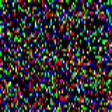

In [15]:
from PIL import Image
import numpy as np

image = np.random.normal(0, 1, size=(48, 80, 3)).astype("uint8")
mean = (128,)
std = (256,)
data = (image - mean)/std
data = data.transpose((2, 0, 1))
data = np.expand_dims(data, 0).astype("float32")
images = np.expand_dims(image, 0)
images.tofile(f"{root_dir}/input.bin")
Image.fromarray(image).resize((112, 112))

In [16]:
from dataclasses import dataclass

@dataclass
class Dataset:
    input_name: str
    shape: tuple

    def __iter__(self):
        for _ in range(2):
            yield {self.input_name: data}
        # for _ in range(50):
        #     yield {self.input_name: np.random.normal(0, 1, size=self.shape).astype("float32")}

dataset = Dataset(input_name, shape)
with relay.quantize.qconfig(
    calibrate_mode="kl_divergence",
    weight_scale="max",
    # vta_adjust_scale = True,  # 跑 vta 时必须开启
    # vta_relu6_flag = True,
    # weight_per_channel_quantization=True,     # 逐通道量化
    # prelu_fuse=True,
    skip_conv_layers=[],
    skip_dense_layer=False,):
    # qmod, record_graphs = relay.quantize.quantize_debug(mod, params, dataset)
    qmod = relay.quantize.quantize(mod, params, dataset)

In [17]:
# QNN 量化的模型
origin_qmod = deepcopy(qmod)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(origin_qmod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
origin_qoutputs = [module.get_output(k).numpy() for k in range(3)]

In [18]:
origin_qmod.show()

In [19]:
class YoloDFLPredictRewrite(DFPatternCallback):
    """融合 (reshape)+cast+multiply+vta_special.vta_yolo_dfl_predict 以更新 x_scale
    """
    def __init__(self):
        super().__init__()
        self.x = wildcard()
        self.reshape = is_op("reshape")(self.x)
        self.cast = is_op("cast")(self.reshape|self.x).has_attr({"dtype": "float32"})
        self.data_scale = is_constant()
        self.multiply = is_op("multiply")(self.cast, self.data_scale)
        self.dfl_predict_call = is_op("vta_special.yolo_dfl")(self.multiply)
        self.pattern = self.dfl_predict_call

    def callback(self, pre, post, node_map):
        x = node_map[self.x][0]
        data_scale = node_map[self.data_scale][0]
        dfl_predict_call = node_map[self.dfl_predict_call][0]
        return yolo_dfl(
            x, dfl_predict_call.attrs.channel, 
            dfl_predict_call.attrs.in_shape, 
            dfl_predict_call.attrs.version,
            float(data_scale.data.numpy())
        )

In [20]:
qmod["main"] = rewrite(YoloDFLPredictRewrite(), qmod["main"])
qmod.show()

In [21]:
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(qmod, target, params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(dev))
module.run(**{input_name: data})
qoutputs = [module.get_output(k).numpy() for k in range(3)]
[np.testing.assert_almost_equal(origin_qoutputs[k], qoutputs[k]) for k in range(3)];